In [1]:
import gradinator as g
from gradinator import Tensor
import numpy as np
from tqdm.notebook import tqdm
import math

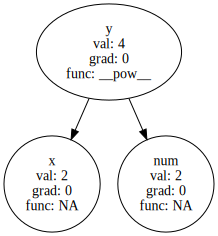

In [2]:
x = Tensor(2)
y = x**2
x.name = 'x'
y.name='y'
y.graph_visualize()



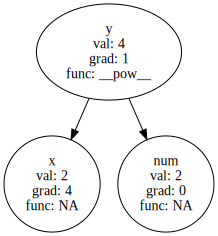

In [3]:
#print(list(x.dependents)[0])
y.back()
y.graph_visualize()

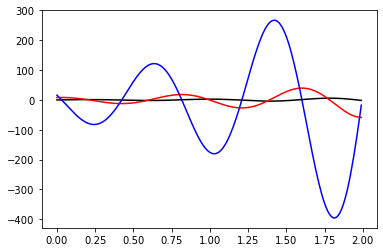

In [6]:
#To test the deriv, you can change the testfunc
import matplotlib.pyplot as plt

def testfunc(x):
    #x = Element(x)
    return (Tensor(np.e)**(x)) * g.sin(x*8)

def getxgrad(x):
    x = Tensor(x)
    testfunc(x).backprop()
    return x

def gethighergrad(x, order = 2):
    x = Tensor(x)
    testfunc(x).backprop()
    for i in range(order-1):
        y = x.grad
        y.flush_grads()
        y.backprop()
    return x.grad.value

range_lower = 0
range_upper = 2
step = 100

range_tuple = (int(range_lower*step),int(range_upper*step))

plt.plot([i/step for i in range(*range_tuple)],[(testfunc(Tensor(x/step)).value) for x in range(*range_tuple)], 'black')
grads = [(getxgrad(x/step).grad.value) for x in range(*range_tuple)]
plt.plot([i/step for i in range(*range_tuple)],grads, 'red')

grads_2 = [(gethighergrad(x/step,2)) for x in range(*range_tuple)]
plt.plot([i/step for i in range(*range_tuple)],grads_2, 'blue')

plt.show();

Tensor(shape: (), val: -2.1273337579063627, grad: 1, function: __mul__, name: y


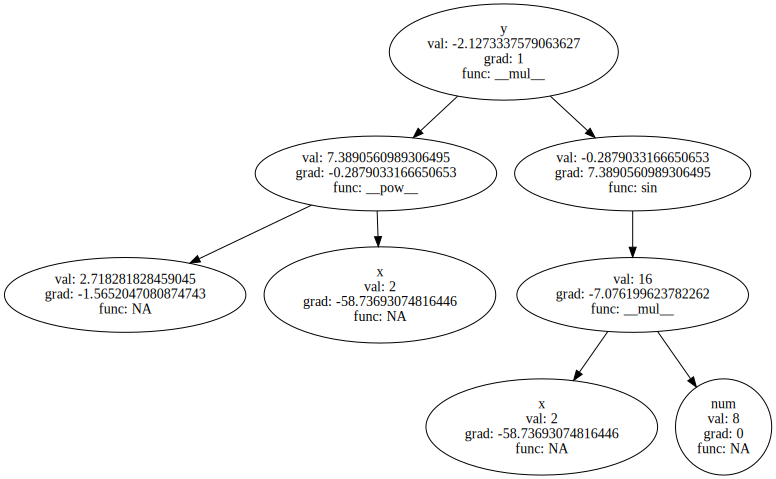

In [7]:
y = testfunc(Tensor(2,name='x'))
y.name='y'
y.backprop()
print(y)
#graph_print(traceback(y))
y.graph_visualize()

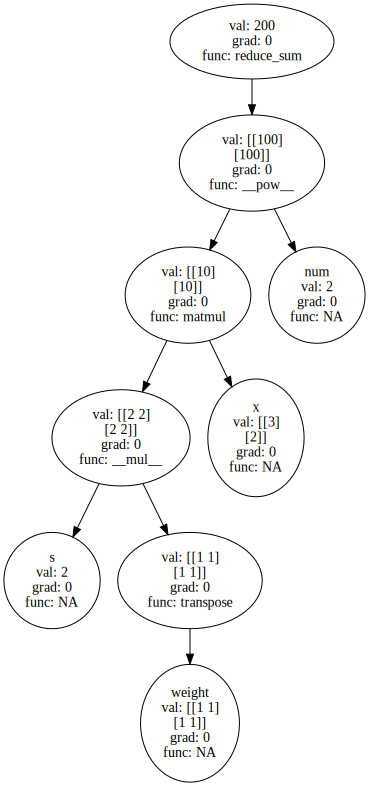

In [8]:
w = Tensor([[1,1],[1,1]],name = 'weight')
x = Tensor([[3],[2]],name = 'x')
s = Tensor(2,name='s')

z = g.reduce_sum(g.matmul(s*g.transpose(w),x) ** 2)
z.graph_visualize()

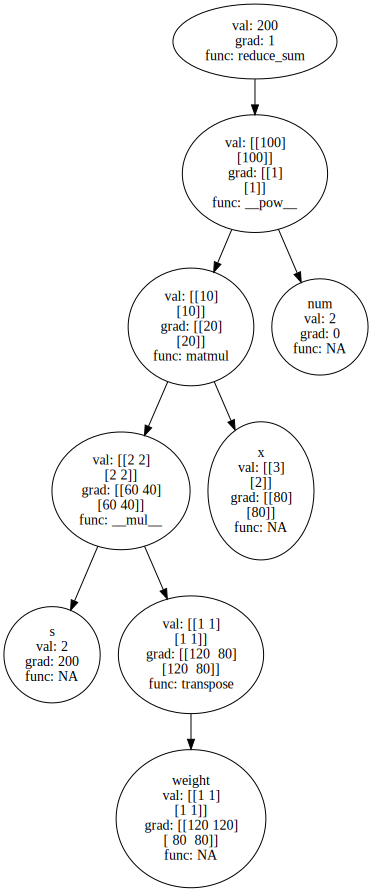

In [9]:
z.backprop()
z.graph_visualize()

#graph_visualize(w.grad)

In [10]:
z.flush_grads()

In [2]:
x = Tensor(np.ones((784,1)),name='x')
w1 = Tensor(math.sqrt(12/794)*(np.random.rand(784,100)-.5),name='w1')
b1 = Tensor(np.zeros((100,1)),name='b1')
w2 = Tensor(math.sqrt(22/110)*(np.random.randn(100,10)-.5),name='w2')
b2 = Tensor(np.zeros((10,1)),name='b2')
w3 = Tensor(math.sqrt(12/110)*(np.random.rand(100,10)-.5),name='w3')
b3 = Tensor(np.zeros((10,1)),name='b3')

params = np.array([w1, b1, w3, b3])

#print(sigmoid(g.matmul(g.transpose(w1),x)))
def sigmoid(x):
    return Tensor(1)/(1+Tensor(np.e)**(-x))

def exponentiate(x):
    return Tensor(np.e)**x

def softmax(logits):
    exp_layer = exponentiate(logits-np.max(logits.value))
    exp_sum = g.reduce_sum(exp_layer)
    return exp_layer / exp_sum

def crossentropy_loss(y_pred, y_truth):
    e_wise_loss = (y_truth)*(g.ln(y_pred))
    loss = -g.reduce_sum(e_wise_loss)
    loss.name = 'loss'
    return loss
    
def l2(x):
    return g.reduce_sum(x**2)**(.5)


def forward(x, label):
    L1 = sigmoid(g.matmul(g.transpose(w1),x)+b1)
    #print(L1)
    #L2 = sigmoid(g.matmul(g.transpose(w2),L1)+b2)
    #print(L2)
    L3 = softmax(g.matmul(g.transpose(w3),L1)+b3)
    #print(L3)
    loss = crossentropy_loss(L3, label if isinstance(label,Tensor) else Tensor(label)) #+ (0.05)*(l2(w1)+l2(b1)+l2(w3)+l2(b3)+l2(w2)+l2(b1))
    #print(L3.value)
    pred = np.argmax(L3.value)
    #print(pred)
    return (loss, pred)

def update(params, grads, learning_rate):
    #print('updating')
    for i in range(len(params)):
        params[i].value = params[i].value - learning_rate*grads[i]

def train(X, Labels, params = None, epochs = 5, learning_rate = 0.001, batch = 100, clip =2000):
    for epoch in range(epochs):
        grads = np.zeros_like(params)
        print('epcoh '+str(epoch))
        print(end='\r')
        acc = 0
        l_acc = []
        l_loss = []
        for idx in tqdm(range(len(X)), desc = str(epoch)):
            loss, pred = forward(X[idx], Labels[idx])
            loss.backprop()
            for i in range(len(params)):
                param_g = params[i].grad.value
                grads[i] += np.clip(param_g, a_min = -clip, a_max=clip)
            loss.flush_grads()
            #print(grads)
            #print(np.argmax(Labels[idx]))
            if pred == np.argmax(Labels[idx]):
                l_acc.append(1)
            else:
                l_acc.append(0)
            l_loss.append(loss.value)
            if len(l_acc)>batch:
                l_acc = l_acc[1:]
                l_loss = l_loss[1:]
                
            
            if (idx+1) % batch == 0:
                #print(end='\r')
                update(params, grads/batch, learning_rate)
                grads = np.zeros_like(params)
                #print('acc: '+str(acc), end="")
                #print(' loss: '+str(l), end="")
            
            if (idx+1) % 100 ==0:
                print(end='\r')
                print('acc: %5.5f'%(acc), end="")
                print(' loss: '+str(l), end="")
                
            #print(pred)
            acc = sum(l_acc)/len(l_acc)
            l = sum(l_loss)/len(l_loss)
            
        #update(params, grads/len(X), learning_rate)
    
#forward(x, Tensor(np.ones((10,1)))).graph_visualize(disp_val = False)


In [3]:
import mnist
from sklearn.preprocessing import OneHotEncoder

images = mnist.train_images()
labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

enc = OneHotEncoder(handle_unknown='ignore')

X = images.reshape((len(images),784,1))
X_test = test_images.reshape((len(test_images), 784,1))

enc.fit(labels.reshape(len(labels),1))
labels_oh = enc.transform(labels.reshape(60000,1)).toarray().reshape((60000,10,1))

enc.fit(test_labels.reshape(len(test_labels),1))
test_labels_oh = enc.transform(test_labels.reshape(10000,1)).toarray().reshape((10000,10,1))
print(X.shape)
print(labels_oh.shape)

(60000, 784, 1)
(60000, 10, 1)


In [ ]:
train(X[:100000], labels_oh[:100000], params = params, epochs=15, learning_rate=0.01,batch=1000)

epcoh 0


acc: 0.72700 loss: 1.4375600803754058 loss: 2.0048947881023826 loss: 1.6477126144888017 loss: 1.6683179545844289 loss: 1.4926835988585152 loss: 1.4758105964139319
epcoh 1


acc: 0.83500 loss: 1.0614132244022536 loss: 1.2736389329035487 loss: 1.2157938318146468
epcoh 2


acc: 0.86900 loss: 0.8623178900401312 loss: 1.066042849652406 loss: 1.0594721547836519
epcoh 3


acc: 0.88300 loss: 0.7372315557700577 loss: 0.8711337398738279 loss: 0.8615742399995315
epcoh 4


acc: 0.89700 loss: 0.6422225304100763 loss: 0.7592305594992264 loss: 0.7973416341733905
epcoh 5


acc: 0.90500 loss: 0.5737849761072962 loss: 0.6986038062983727 loss: 0.675386179226039 loss: 0.6972602714780857
epcoh 6


acc: 0.90600 loss: 0.52793488605026627loss: 0.600741482580107 loss: 0.49225123753837
epcoh 7


acc: 0.91300 loss: 0.48661458720355677loss: 0.6271363579483904
epcoh 8


acc: 0.91500 loss: 0.45470722180035244 loss: 0.552461030841747 loss: 0.6284591904254859 loss: 0.5390559123025889
epcoh 9


acc: 0.85500 loss: 0.58182197649392183 loss: 0.5726265211088392 loss: 0.5611436006343355

In [ ]:
l,p = forward(X[0],label = labels_oh[0])
print(p)
l.flush_grads()
l.backprop()
print(l.parents)
#print(b2)
print(str(w2)+'\n\n\n\n')
print(str(w1)+'\n\n\n\n')
print(w3)
#b1.grad.graph_visualize()

5


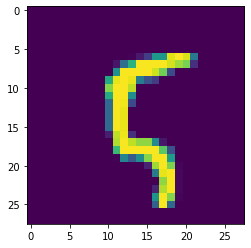

In [100]:
import matplotlib.pyplot as plt

i=100
plt.imshow(images[i])
print(np.argmax(labels_oh[i]))
plt.show()

Tensor(shape: (2,), val: [0 1], grad: 0, function: relu


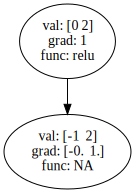

In [10]:
print(g.relu([-1,1]))
y = g.relu(Tensor([-1,2]))
y.backprop()
y.graph_visualize()

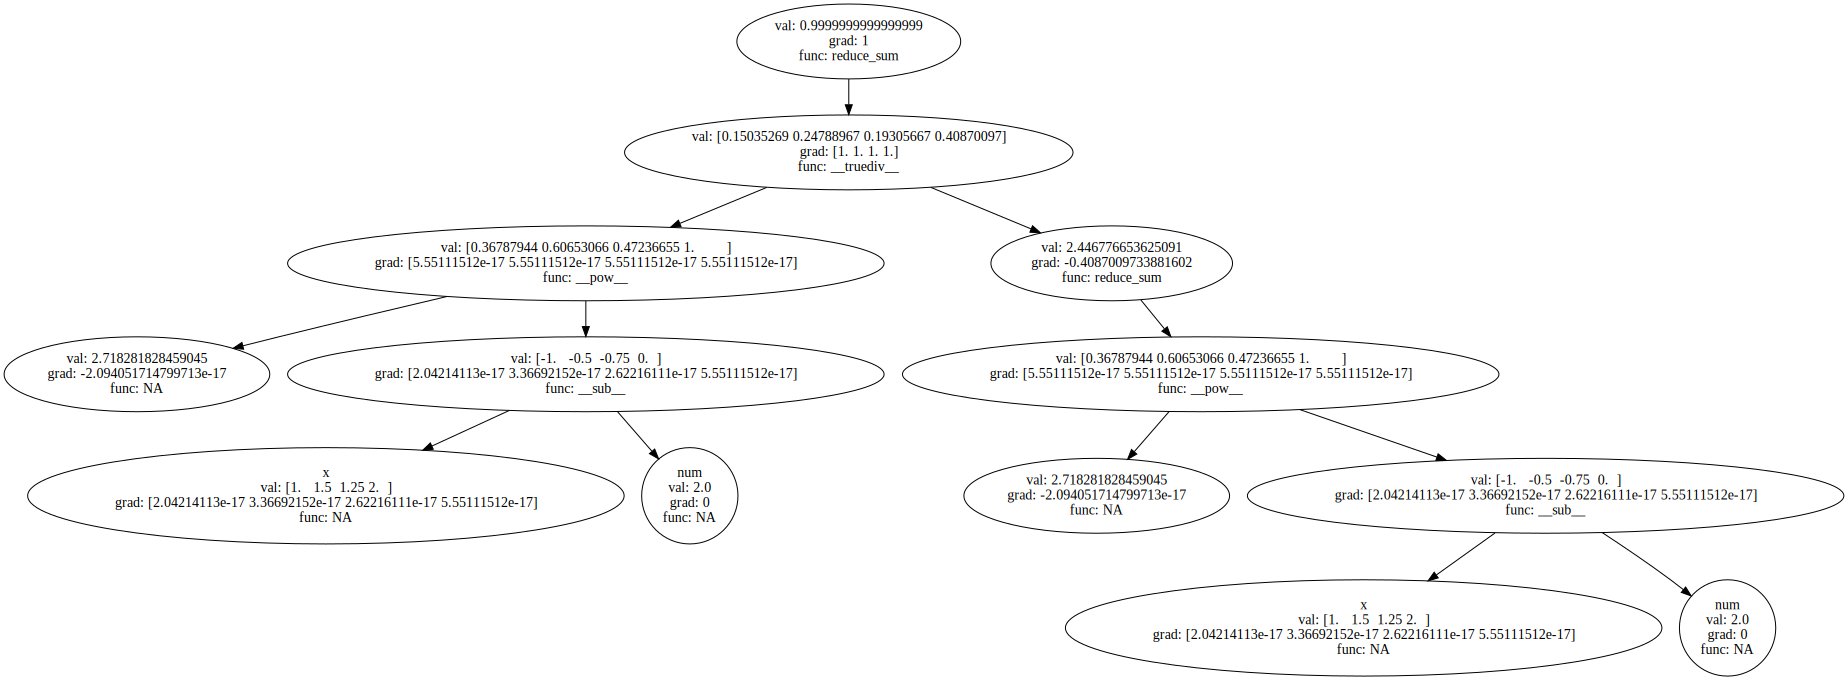

In [12]:
exp = softmax(Tensor([1,1.5,1.25,2],name='x'))
y = g.reduce_sum(exp)
y.backprop()
y.graph_visualize()
#exp.graph_visualize()